# Analyzing Stock Price Volatility and Predicting Price Movements

GOAL:

The objective of this project is to analyze NVIDIA's historical stock price data, measure volatility, and build a predictive model to forecast future price movements.

I found interest in NVIDIA because it was part of my investment portfolio before the recent spike in stock price. I speculated a rise in price when the CHIPS act was passed, which provided over 200 billion dollars in research funding for the manufacturing of semiconductor chips in the US. However, I'm curious to see if my analysis of the stock could provide financial indicators of price hikes.

Challenges:
At first, I struggled to properly work with time series data, as I treated it like normal tabular data. After adapting to the datetime index by exploring methods of data manipulation, data wrangling was much easier. Arguebly the biggest challenge I faced, however, was working with the JSON data. The alphavantage API that I used, returned data that was not for the specified period, but a much shorter frame of time. This meant that I had to maunally load the relevant data into a list after parsing the JSON data. After doing that, I felt much more comfortable working with JSON. 

## Data Collection

For this project, I chose to use the Yahoo finance API to retrieve data on NVIDIA as the website is familiar to me, allowing me to navigate an interface while conducting my analysis. 

In [ ]:
# Installing dependencies
# ! pip install pandas-datareader 
# ! pip install yfinance
# ! pip install Tiingo
# ! pip install requests
# ! pip install datetime
# ! pip install xgboost

In [36]:
# Importing necessary libraries

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime

# Machine learning library
import xgboost as xgb
from sklearn.metrics import mean_squared_error



## Exploratory Data Analysis

In [7]:
# Setting the start and end dates for the data to look back five years
start_date = '2022-01-01'
end_date = '2023-06-01'

# Fetching the historical stock price data using yfinance
nvidia_data = yf.download('NVDA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [8]:
# The first few rows of the data
print(nvidia_data.head())

# The data types of the columns
nvidia_data.info()

# Basic statistical analysis
nvidia_data.describe()

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  298.149994  307.109985  297.850006  301.209991  300.846375   
2022-01-04  302.769989  304.679993  283.489990  292.899994  292.546417   
2022-01-05  289.489990  294.160004  275.329987  276.040009  275.706787   
2022-01-06  276.399994  284.380005  270.649994  281.779999  281.439850   
2022-01-07  281.410004  284.220001  270.570007  272.470001  272.141083   

              Volume  
Date                  
2022-01-03  39154700  
2022-01-04  52715400  
2022-01-05  49806400  
2022-01-06  45418600  
2022-01-07  40993900  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354 entries, 2022-01-03 to 2023-05-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       354 non-null    float64
 1   High       354 non-null    float64
 2   Low        354 non-null    float

,Open,High,Low,Close,Adj Close,Volume
count,354.000000,354.000000,354.000000,354.000000,354.000000,3.540000e+02
mean,203.115226,207.867175,198.574520,203.436158,203.308661,5.270577e+07
std,55.554049,56.381216,54.452931,55.364360,55.344868,1.495569e+07
min,109.709999,117.349998,108.129997,112.269997,112.210609,1.679340e+07
25%,160.199997,163.427505,155.992500,159.904995,159.861298,4.277768e+07
50%,188.380005,193.345001,185.089996,189.094994,188.918839,5.031755e+07
75%,244.537502,251.727505,238.930000,244.935005,244.670570,5.939425e+07
max,405.950012,419.380005,399.489990,401.109985,401.068481,1.543911e+08


Interestingly, EDA reflects the stock price hike to some extent, with the 75th percentile of all 1127 records being less than half of the current price (about 420 USD today). In the data visualization section (next), we will see this hike, which is relatively abrupt.  

## Data Visualization

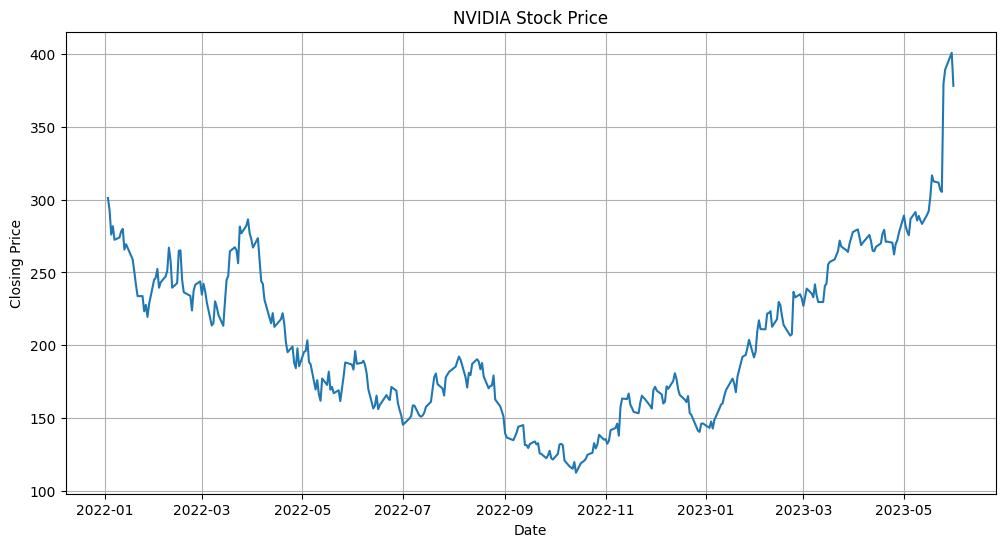

In [9]:
# Plotting the closing price over time
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data.index, nvidia_data['Close'])
plt.title('NVIDIA Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

### Volatility Analysis
Now analyzing the volatility of NVIDIA through the standard deviation of returns. I use a window of 30 in the rolling standard deviation to reflect monthly volitility.

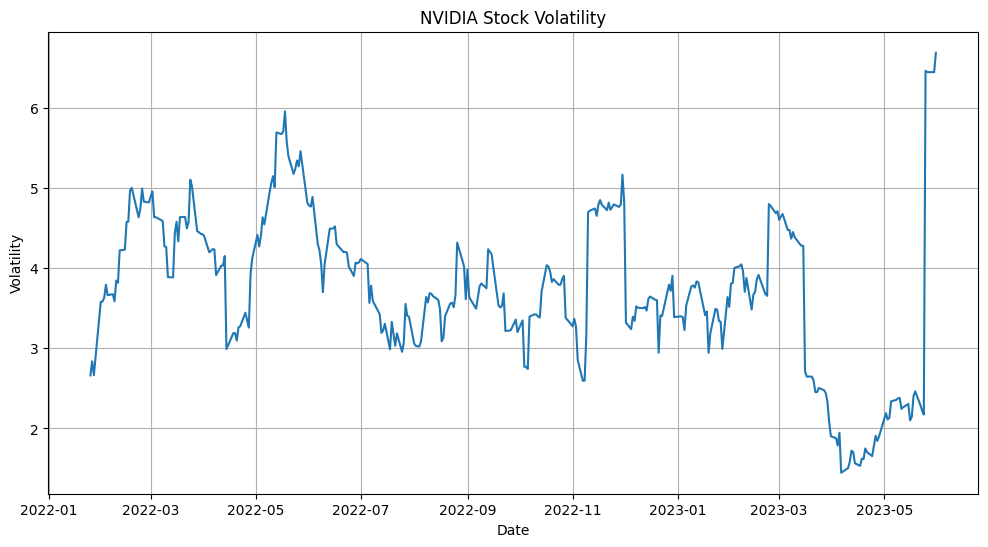

In [10]:
# Looking at daily returns 
nvidia_data['Daily_Return'] = nvidia_data['Close'].pct_change()

# Calculating volatility by looking at the std of daily returns over a period of 15 days
window_size = 15  
nvidia_data['Volatility'] = nvidia_data['Daily_Return'].rolling(window_size).std().apply(lambda x: x*100)

# Visualizing volatility for analysis
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data.index, nvidia_data['Volatility'])
plt.title('NVIDIA Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [11]:
nvidia_data['Volatility'].describe()

count    339.000000
mean       3.706067
std        0.956296
min        1.448624
25%        3.223074
50%        3.679772
75%        4.375422
max        6.684492
Name: Volatility, dtype: float64

Notable patterns in volatility and stock price: Dips in volatility usually correspond to plateus in price, while spikes correspond to lower prices. Looking at the statistical analysis of stock volatility, we can reasonable assume that a volatility greater than the 75th percentile is 'high', while a volatility lower than the 25th percentile is 'low'. 

## Feature Engineering

With the goal of capturing technical and non-technical indicators of price hikes, I will include the relative strength index (RSI) to record momentum for my technical indicator and a medium of financial news sentiment analysis for my non-technical indicator.

In [12]:
# Building RSI to capture the speed and change of price movements using historical data

# Calculating price change
nvidia_data['Price_Change'] = nvidia_data['Close'].diff()

# Defining the lookback periods
weekly_lookback_period = 7
biweekly_lookback_period = 14
monthly_lookback_period = 30

# Calculating the average gain and average loss
nvidia_data['Gain'] = nvidia_data['Price_Change'].where(nvidia_data['Price_Change'] > 0, 0)
nvidia_data['Loss'] = -nvidia_data['Price_Change'].where(nvidia_data['Price_Change'] < 0, 0)

# Calculating for different time windows
nvidia_data['Average_Weekly_Gain'] = nvidia_data['Gain'].rolling(weekly_lookback_period).mean()
nvidia_data['Average_Weekly_Loss'] = nvidia_data['Loss'].rolling(weekly_lookback_period).mean()
nvidia_data['Average_BiWeekly_Gain'] = nvidia_data['Gain'].rolling(biweekly_lookback_period).mean()
nvidia_data['Average_BiWeekly_Loss'] = nvidia_data['Loss'].rolling(biweekly_lookback_period).mean()
nvidia_data['Average_Monthly_Gain'] = nvidia_data['Gain'].rolling(monthly_lookback_period).mean()
nvidia_data['Average_Monthly_Loss'] = nvidia_data['Loss'].rolling(monthly_lookback_period).mean()

# Calculating the relative strength (RS)
nvidia_data['RS-Week'] = nvidia_data['Average_Weekly_Gain'] / nvidia_data['Average_Weekly_Loss']
nvidia_data['RS-2Weeks'] = nvidia_data['Average_BiWeekly_Gain'] / nvidia_data['Average_BiWeekly_Loss']
nvidia_data['RS-Month'] = nvidia_data['Average_Monthly_Gain'] / nvidia_data['Average_Monthly_Loss']

# Calculating the RSI

nvidia_data['RSI-Week'] = 100 - (100 / (1 + nvidia_data['RS-Week']))
nvidia_data['RSI-2Weeks'] = 100 - (100 / (1 + nvidia_data['RS-2Weeks']))
nvidia_data['RSI-Month'] = 100 - (100 / (1 + nvidia_data['RS-Month']))

nvidia_data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Volatility,Price_Change,Gain,...,Average_BiWeekly_Gain,Average_BiWeekly_Loss,Average_Monthly_Gain,Average_Monthly_Loss,RS-Week,RS-2Weeks,RS-Month,RSI-Week,RSI-2Weeks,RSI-Month
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,298.149994,307.109985,297.850006,301.209991,300.846375,39154700,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,302.769989,304.679993,283.489990,292.899994,292.546417,52715400,-0.027589,NaN,-8.309998,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,289.489990,294.160004,275.329987,276.040009,275.706787,49806400,-0.057562,NaN,-16.859985,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,276.399994,284.380005,270.649994,281.779999,281.439850,45418600,0.020794,NaN,5.739990,5.739990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07,281.410004,284.220001,270.570007,272.470001,272.141083,40993900,-0.033040,NaN,-9.309998,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,302.100006,306.070007,298.059998,305.380005,305.348419,72141900,-0.004888,2.173517,-1.500000,0.000000,...,3.743574,1.617859,3.131001,1.783334,2.390352,2.313906,1.755700,70.504539,69.824132,63.711584
2023-05-25,385.230011,394.799988,366.350006,379.799988,379.760681,154391100,0.243696,6.458946,74.419983,74.419983,...,8.260716,1.617859,5.611667,1.772667,8.690353,5.105956,3.165663,89.680459,83.622548,75.994215
2023-05-26,378.899994,391.700012,375.500000,389.459991,389.419678,71439700,0.025434,6.441880,9.660004,9.660004,...,8.614286,1.617859,5.835334,1.772667,8.691232,5.324498,3.291838,89.681394,84.188468,76.699960


Checking For Missing Values 

In [13]:
nvidia_data.isnull().sum()

Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
Daily_Return              1
Volatility               15
Price_Change              1
Gain                      0
Loss                      0
Average_Weekly_Gain       6
Average_Weekly_Loss       6
Average_BiWeekly_Gain    13
Average_BiWeekly_Loss    13
Average_Monthly_Gain     29
Average_Monthly_Loss     29
RS-Week                   6
RS-2Weeks                13
RS-Month                 29
RSI-Week                  6
RSI-2Weeks               13
RSI-Month                29
dtype: int64

In [14]:
# Cropping Dataset to get rid of null values
nvidia_data1 = nvidia_data.copy()
nvidia_data2 = nvidia_data1.iloc[41:]

nvidia_data2.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
Daily_Return             0
Volatility               0
Price_Change             0
Gain                     0
Loss                     0
Average_Weekly_Gain      0
Average_Weekly_Loss      0
Average_BiWeekly_Gain    0
Average_BiWeekly_Loss    0
Average_Monthly_Gain     0
Average_Monthly_Loss     0
RS-Week                  0
RS-2Weeks                0
RS-Month                 0
RSI-Week                 0
RSI-2Weeks               0
RSI-Month                0
dtype: int64

In [15]:
url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=NVDA&time_from=20221220T0000&time_to=20220225T0000&sort=EARLIEST&limit=1000&apikey=key'
r = requests.get(url)
data = r.json()


In [16]:
# Creating non-technical feature - sentiment score
sentiment_data = data['feed']
date_pub = [item['time_published'] for item in sentiment_data]
ticker_sentiment = [item['ticker_sentiment'] for item in sentiment_data]


In [19]:
def date_mod(old_date):
    x = old_date
    year = x[:4]
    month = x[4:6]
    day = x[6:8]
    new_date = f"{year}-{month}-{day}"
    return new_date

ticker_ = []
for i in ticker_sentiment:
    for z in i:
        if z['ticker'] == 'NVDA':
            ticker_.append((date_mod(date_pub[ticker_sentiment.index(i)]),z))
        else:
            pass

sen_by_date={}

for y in ticker_:
    sen_by_date[y[0]]=float(y[1]['ticker_sentiment_score'])

In [788]:
print(sen_by_date)

{'2021-12-17': 0.119922, '2022-01-07': 0.175507, '2022-01-11': 0.145419, '2022-01-20': -0.41337, '2022-01-22': 0.017226, '2022-01-29': -0.292635, '2022-02-10': -0.103235, '2022-02-12': 0.280657, '2022-02-25': 0.027211, '2022-03-03': 0.025975, '2022-03-04': -0.361876, '2022-03-06': -0.482104, '2022-03-07': -0.100557, '2022-03-08': 0.029325, '2022-03-09': 0.110153, '2022-03-10': -0.213139, '2022-03-11': 0.009044, '2022-03-12': 0.02062, '2022-03-14': -0.51159, '2022-03-15': -0.022938, '2022-03-16': 0.039266, '2022-03-17': 0.208008, '2022-03-18': 0.263575, '2022-03-19': -0.023456, '2022-03-20': 0.115607, '2022-03-21': 0.006097, '2022-03-22': 0.110067, '2022-03-23': -0.280606, '2022-03-24': 0.328963, '2022-03-25': 0.027994, '2022-03-26': 0.054811, '2022-03-27': 0.018851, '2022-03-28': 0.102877, '2022-03-29': 0.152896, '2022-03-30': 0.033557, '2022-03-31': 0.076456, '2022-04-01': -0.84123, '2022-04-02': -0.059867, '2022-04-03': 0.030676, '2022-04-04': 0.014485, '2022-04-05': 0.145717}


Alphavantage API only provided data in monthly periods - as seen above - which meant that I had to more manually create the list of sentiment scores.

In [20]:
sentiment_by_date={'2022-03-03': 0.025975, '2022-03-04': -0.361876, '2022-03-06': -0.482104, '2022-03-07': -0.100557, '2022-03-08': 0.029325, '2022-03-09': 0.110153, '2022-03-10': -0.213139, '2022-03-11': 0.009044, '2022-03-12': 0.02062, '2022-03-14': -0.51159, '2022-03-15': -0.022938, '2022-03-16': 0.039266, '2022-03-17': 0.208008, '2022-03-18': 0.263575, '2022-03-19': -0.023456, '2022-03-20': 0.115607, '2022-03-21': 0.006097, '2022-03-22': 0.110067, '2022-03-23': -0.280606, '2022-03-24': 0.328963, '2022-03-25': 0.027994, '2022-03-26': 0.054811, '2022-03-27': 0.018851, '2022-03-28': 0.102877, '2022-03-29': 0.152896, '2022-03-30': 0.033557, '2022-03-31': 0.076456, '2022-04-01': -0.84123, '2022-04-02': -0.059867, '2022-04-03': 0.030676, '2022-04-04': 0.014485, '2022-04-05': 0.146461, '2022-04-06': 0.058216, '2022-04-07': 0.106716, '2022-04-08': 0.002513, '2022-04-09': 0.002527, '2022-04-10': 0.463426, '2022-04-11': -0.517256, '2022-04-12': -0.905462, '2022-04-13': -0.017828, '2022-04-14': -0.428593, '2022-04-15': 7.2e-05, '2022-04-16': 0.539036, '2022-04-18': -0.184564, '2022-04-19': 0.047192, '2022-04-20': -0.01629, '2022-04-21': -0.512638, '2022-04-22': -0.211386, '2022-04-23': 0.365952, '2022-04-24': -0.211386, '2022-04-25': 0.099542, '2022-04-26': -0.052864, '2022-04-27': 0.135854, '2022-04-28': -0.270361, '2022-04-29': -0.008439, '2022-04-30': -0.063814, '2022-05-02': 0.014942, '2022-05-03': 0.036601, '2022-05-04': -0.646866, '2022-05-05': -0.217598, '2022-05-06': 0.29925, '2022-05-07': 0.002596, '2022-05-08': -0.258068, '2022-05-09': -0.876185, '2022-05-10': 0.010412, '2022-05-11': -0.254885, '2022-05-12': 0.085348, '2022-05-13': 0.314548, '2022-05-14': 0.212614, '2022-05-15': 0.039001, '2022-05-16': 0.039712, '2022-05-17': -0.204141, '2022-05-18': 0.02011, '2022-05-19': -0.000117, '2022-05-20': -0.00017, '2022-05-21': -0.106016, '2022-05-22': 0.056097, '2022-05-23': -0.055835, '2022-05-24': 0.049533, '2022-05-25': 0.143948, '2022-05-26': 0.157246, '2022-05-27': 0.018143, '2022-05-28': 0.020813, '2022-05-29': -0.256858, '2022-05-30': 0.086394, '2022-05-31': 0.525861, '2022-06-01': 0.033533, '2022-06-02': -0.031109, '2022-06-03': 0.031183, '2022-06-04': 0.063776, '2022-06-05': 0.047457, '2022-06-06': 0.000524, '2022-06-07': -0.028919, '2022-06-08': -0.867247, '2022-06-09': 0.056011, '2022-06-10': 0.027057, '2022-06-11': 0.142196, '2022-06-12': 0.056183, '2022-06-13': -0.243362, '2022-06-14': -0.117257, '2022-06-15': 0.059886, '2022-06-16': -0.076285, '2022-06-17': -0.248622, '2022-06-19': -0.234255, '2022-06-20': 0.056204, '2022-06-21': -0.004501, '2022-06-22': 0.015744, '2022-06-23': 0.107511, '2022-06-24': 0.303515, '2022-06-25': -0.061442, '2022-06-26': 0.20354, '2022-06-27': 0.471808, '2022-06-28': -0.171523, '2022-06-29': 0.000637, '2022-06-30': -0.117173, '2022-07-01': -0.150968, '2022-07-02': 0.088277, '2022-07-03': 0.142472, '2022-07-04': 0.899606, '2022-07-05': -0.004561, '2022-07-06': 0.956377, '2022-07-07': 0.143557, '2022-07-08': 0.093879, '2022-07-09': 0.099166, '2022-07-10': 0.050751, '2022-07-11': 0.424359, '2022-07-12': 0.247114, '2022-07-13': -0.463369, '2022-07-14': 0.0, '2022-07-15': 0.0, '2022-07-16': 0.137154, '2022-07-18': 0.00305, '2022-07-19': 0.024003, '2022-07-20': 0.400456, '2022-07-21': 0.096795, '2022-07-22': 0.383415, '2022-07-23': 0.484713, '2022-07-24': 0.101865, '2022-07-25': 0.076211, '2022-07-26': 0.00415, '2022-07-27': -0.037032, '2022-07-28': 0.209112, '2022-07-29': 0.042275, '2022-07-30': 0.095076, '2022-07-31': 0.0, '2022-08-01': 0.341098, '2022-08-02': -0.004004, '2022-08-03': 0.313531, '2022-08-04': 0.287516, '2022-08-05': -0.084481, '2022-08-06': 0.045425, '2022-08-07': 0.096676, '2022-08-08': -0.748739, '2022-08-09': -0.174232, '2022-08-10': 0.073319, '2022-08-11': -0.128918, '2022-08-12': -0.523454, '2022-08-13': 0.038227, '2022-08-14': -0.006302, '2022-08-15': 0.072316, '2022-08-16': 0.118751, '2022-08-17': 0.0, '2022-08-18': 0.025533, '2022-08-19': -0.053435, '2022-08-20': -0.05999, '2022-08-21': 0.367404, '2022-08-22': 0.164558, '2022-08-23': 0.01576, '2022-08-24': -0.042021, '2022-08-25': -0.18879, '2022-08-26': 0.087426, '2022-08-27': 0.147989, '2022-08-28': 0.124081, '2022-08-29': -0.096685, '2022-08-30': 0.085873, '2022-08-31': 0.123867, '2022-09-01': 0.212782, '2022-09-02': 0.260238, '2022-09-03': 0.213927, '2022-09-04': 0.382428, '2022-09-05': 0.1623, '2022-09-06': -0.129079, '2022-09-07': -0.086481, '2022-09-08': -0.173872, '2022-09-09': 0.246259, '2022-09-10': 0.081705, '2022-09-11': 0.07372, '2022-09-12': 0.161193, '2022-09-13': 0.006864, '2022-09-14': 0.103133, '2022-09-15': 0.075556, '2022-09-16': 0.13491, '2022-09-17': -0.554671, '2022-09-18': 0.000924, '2022-09-19': 0.18707, '2022-09-20': 0.292225, '2022-09-21': 0.092818, '2022-09-22': 0.235589, '2022-09-23': -0.084164, '2022-09-24': -0.020214, '2022-09-25': 0.225757, '2022-09-26': -0.177422, '2022-09-27': -0.062128, '2022-09-28': -0.041867, '2022-09-29': 0.232914, '2022-09-30': 0.387251, '2022-10-01': 0.162591, '2022-10-02': 0.080806, '2022-10-03': 0.054436, '2022-10-04': -0.083959, '2022-10-05': 0.259951, '2022-10-06': -0.116712, '2022-10-07': -0.049001, '2022-10-08': -0.193224, '2022-10-09': 0.159183, '2022-10-10': 0.050232, '2022-10-11': 0.275981, '2022-10-12': 0.347318, '2022-10-13': -0.067682, '2022-10-14': -0.087863, '2022-10-15': 0.051726, '2022-10-16': -0.067587, '2022-10-17': 0.041743, '2022-10-18': 0.353381, '2022-10-19': 0.303632, '2022-10-20': 0.168051, '2022-10-21': -0.064025, '2022-10-22': -0.106355, '2022-10-23': 0.162918, '2022-10-24': 0.249542, '2022-10-25': -0.052828, '2022-10-26': 0.388831, '2022-10-27': 0.158059, '2022-10-28': 0.049553, '2022-10-29': 0.466841, '2022-10-30': 0.380389, '2022-10-31': 0.102737, '2022-11-01': 0.536032, '2022-11-02': 0.158317, '2022-11-03': 0.191329, '2022-11-04': -0.092299, '2022-11-05': 0.257848, '2022-11-06': 0.034618, '2022-11-07': 0.30946, '2022-11-08': 0.128501, '2022-11-09': -0.046674, '2022-11-10': -0.128357, '2022-11-11': 0.0, '2022-11-12': 0.184647, '2022-11-13': 0.0, '2022-11-14': 0.060574, '2022-11-15': 0.103921, '2022-11-16': -0.104138, '2022-11-17': -0.103842, '2022-11-18': 0.583996, '2022-11-19': 0.161045, '2022-11-20': 0.214732, '2022-11-21': 0.189092, '2022-11-22': 0.074805, '2022-11-23': 0.141071, '2022-11-24': -0.004057, '2022-11-25': 0.016631, '2022-11-26': 0.476359, '2022-11-27': 0.040089, '2022-11-28': 0.24944, '2022-11-29': -0.138028, '2022-11-30': 0.111825, '2022-12-01': 0.374689, '2022-12-02': 0.001333, '2022-12-03': 0.00133, '2022-12-04': 0.43285, '2022-12-05': 0.281908, '2022-12-06': 0.0, '2022-12-07': 0.355335, '2022-12-08': 0.148378, '2022-12-09': 0.147562, '2022-12-10': 0.405602, '2022-12-11': 0.0, '2022-12-12': 0.03975, '2022-12-13': 0.117561, '2022-12-14': 0.392161, '2022-12-15': 0.096805, '2022-12-16': -0.218634, '2022-12-17': 0.0, '2022-12-18': -0.213062, '2022-12-19': -0.061401, '2022-12-20': 0.035718, '2022-12-21': 0.0, '2022-12-22': -0.425242, '2022-12-23': -0.061185, '2022-12-24': 0.184955, '2022-12-25': 0.256972, '2022-12-26': -0.009635, '2022-12-27': -0.30548, '2022-12-28': -0.360103, '2022-12-29': 0.012968, '2022-12-30': 0.018979, '2022-12-31': -0.095363, '2023-01-01': 0.0, '2023-01-02': 0.063069, '2023-01-03': 0.134881, '2023-01-04': 0.437371, '2023-01-05': 0.11283, '2023-01-06': 0.057202, '2023-01-07': -0.002338, '2023-01-08': 0.158062, '2023-01-09': 0.387251, '2023-01-10': 0.277241, '2023-01-11': 0.122088, '2023-01-12': 0.135885, '2023-01-13': 0.049451, '2023-01-14': 0.0, '2023-01-15': 0.030473, '2023-01-16': 0.017489, '2023-01-17': -0.040744, '2023-01-18': 0.197961, '2023-01-19': 0.006851, '2023-01-20': 0.046615, '2023-01-21': 0.113416, '2023-01-22': 0.309916, '2023-01-23': 0.11116, '2023-01-24': 0.144328, '2023-01-25': 0.320133, '2023-01-26': 0.0, '2023-01-27': -0.007674, '2023-01-28': 0.181869, '2023-01-29': -0.015139, '2023-01-30': 0.0, '2023-01-31': -0.002622, '2023-02-01': 0.235123,'2023-02-02': 0.396391, '2023-02-03': 0.205763, '2023-02-04': 0.07737, '2023-02-05': 0.198134, '2023-02-06': 0.173348, '2023-02-07': 0.092678, '2023-02-08': 0.0, '2023-02-09': 0.128197, '2023-02-10': 0.387251, '2023-02-11': 0.243708, '2023-02-12': 0.085936, '2023-02-13': 0.628819, '2023-02-14': 0.081389, '2023-02-15': 0.314048, '2023-02-16': 0.033307, '2023-02-17': 0.095617, '2023-02-18': 0.033722, '2023-02-19': 0.0, '2023-02-20': -0.035754, '2023-02-21': -0.123019, '2023-02-22': 0.450809, '2023-02-23': 0.103382, '2023-02-24': 0.285411, '2023-02-25': -0.035043, '2023-02-26': -0.03145, '2023-02-27': 0.559192, '2023-02-28': 0.062464, '2023-03-01': 0.180158, '2023-03-02': 0.278258, '2023-03-03': 0.393828, '2023-03-04': 0.146681, '2023-03-05': 0.330093, '2023-03-06': 0.177554, '2023-03-07': -0.118118, '2023-03-08': 0.051776, '2023-03-09': 0.49628, '2023-03-10': 0.243324, '2023-03-11': 0.236779, '2023-03-12': 0.333924, '2023-03-13': 0.189104, '2023-03-14': -0.48781, '2023-03-15': 0.387251, '2023-03-16': 0.614444, '2023-03-17': 0.140852, '2023-03-18': 0.18604, '2023-03-19': 0.117514, '2023-03-20': 0.1607, '2023-03-21': -0.009168, '2023-03-22': 0.033677, '2023-03-23': 0.034255, '2023-03-24': 0.058657, '2023-03-25': -0.075126, '2023-03-26': 0.011011, '2023-03-27': -0.001068, '2023-03-28': 0.156852, '2023-03-29': 0.06134, '2023-03-30': 0.0, '2023-03-31': 0.70619, '2023-04-01': -0.091876, '2023-04-02': 0.163463, '2023-04-03': -0.012086, '2023-04-04': 0.66333, '2023-04-05': 0.236639, '2023-04-06': 0.13871, '2023-04-07': 0.316081, '2023-04-08': 0.399459, '2023-04-09': 0.326329, '2023-04-10': 0.0, '2023-04-11': 0.322994, '2023-04-12': 0.303027, '2023-04-13': 0.065809, '2023-04-14': -0.103259, '2023-04-15': 0.18284, '2023-04-16': 0.086296, '2023-04-17': 0.314379, '2023-04-18': 0.246546, '2023-04-19': -0.11496, '2023-04-20': 0.062062, '2023-04-21': 0.393296, '2023-04-22': 0.245767, '2023-04-23': 0.55179, '2023-04-24': 0.129638, '2023-04-25': 0.271186, '2023-04-26': -0.044416, '2023-04-27': -0.185013, '2023-04-28': 0.155468, '2023-04-29': -0.122526, '2023-04-30': 0.169404, '2023-05-01': 0.0, '2023-05-02': 0.126249, '2023-05-03': 0.15332, '2023-05-04': 0.046834, '2023-05-05': 0.230709, '2023-05-06': 0.291728, '2023-05-07': -0.010986, '2023-05-08': 0.172946, '2023-05-09': 0.210161, '2023-05-10': 0.0, '2023-05-11': 0.388042, '2023-05-12': 0.007694, '2023-05-13': 0.074195, '2023-05-14': 0.245664, '2023-05-15': 0.170142, '2023-05-16': 0.046771, '2023-05-17': 0.246612, '2023-05-18': -0.090258, '2023-05-19': 0.295483, '2023-05-20': 0.169549, '2023-05-21': 0.213394, '2023-05-22': 0.162565, '2023-05-23': 0.046456, '2023-05-24': 0.419344, '2023-05-25': 0.0, '2023-05-26': 0.69853, '2023-05-27': 0.636194, '2023-05-28': 0.193983, '2023-05-29': 0.080415, '2023-05-30': 0.259268, '2023-05-31': 0.132354, '2023-06-01': 0.094445, '2023-06-02': 0.086046, '2023-06-03': 0.044646, '2023-06-04': 0.109391, '2023-06-05': 0.783544, '2023-06-06': 0.406961, '2023-06-07': 0.277694, '2023-06-08': 0.0, '2023-06-09': 0.624195, '2023-06-10': -0.019407, '2023-06-11': 0.465292, '2023-06-12': 0.250066, '2023-06-13': 0.245787, '2023-06-14': 0.0, '2023-06-15': 0.299027, '2023-06-16': 0.027168, '2023-06-17': 0.234578, '2023-06-18': 0.042994, '2023-06-19': -0.036923, '2023-06-20': 0.403623, '2023-06-21': -0.124195, '2023-06-22': -0.090497, '2023-06-23': 0.014305}

In [22]:
#Converting api to datetime object to be comparable to date from main dataframe and then putting them in a list
API_Dates = list(sentiment_by_date.keys())
API_D = []
for date in API_Dates:
    date_str = datetime.strptime(date,'%Y-%m-%d').date()
    API_D.append(date_str)
    


In [23]:
print(len(nvidia_data2))
print(len(sentiment_by_date))

313
472


In [ ]:
# As seen above, there are more records in the sentiment by date dictionary than the df, which must be filtered 
API_D2 = []
for date in nvidia_data2.index:
    strdate = date.strftime('%Y-%m-%d')
    API_D2.append(strdate)
    
# Creating another dictionary that includes the filtered values
final_dict ={}
for date in API_D2:
    senti=sentiment_by_date[date]
    final_dict[date]=senti

# Converting dictionary keys to datetime objects
final_dict = {pd.to_datetime(key): value for key, value in final_dict.items()}

# Updating Sentiment_score column
nvidia_data2['Sentiment_score'] = nvidia_data2.index.map(lambda x: final_dict.get(x, None))

In [135]:
# Rounding values and cleaning up outliers
df = round(nvidia_data2, 3)
df = df.drop(columns=['RS-Week','RS-2Weeks','RS-Month'])
df_col = list(df.columns)


## Train/Test Split

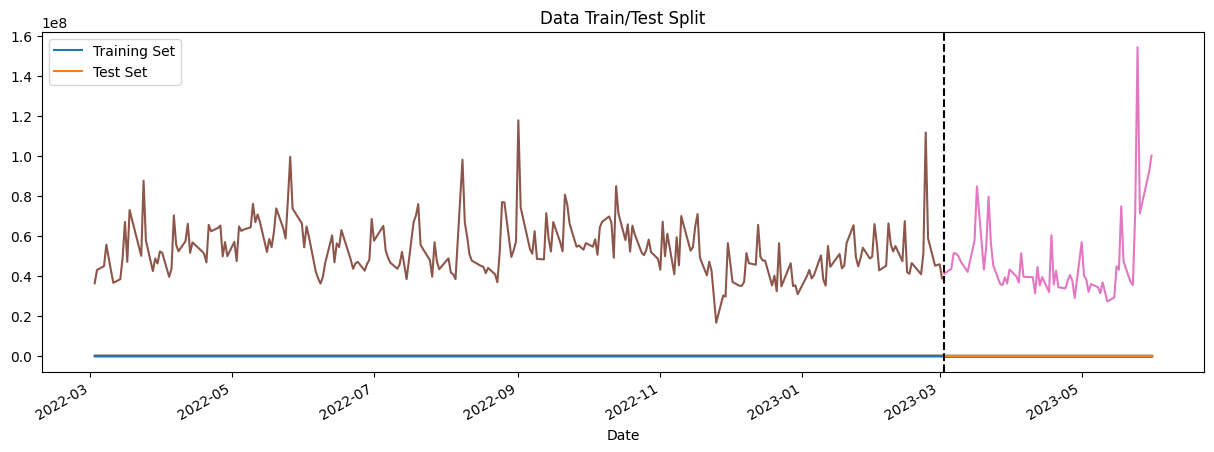

In [136]:
train = df.loc[df.index < '2023-03-03']
test = df.loc[df.index >= '2023-03-03']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-03-03', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [128]:
# Creating features based on more granular time units
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Visualizing data through different time periods

<IPython.core.display.Javascript object>

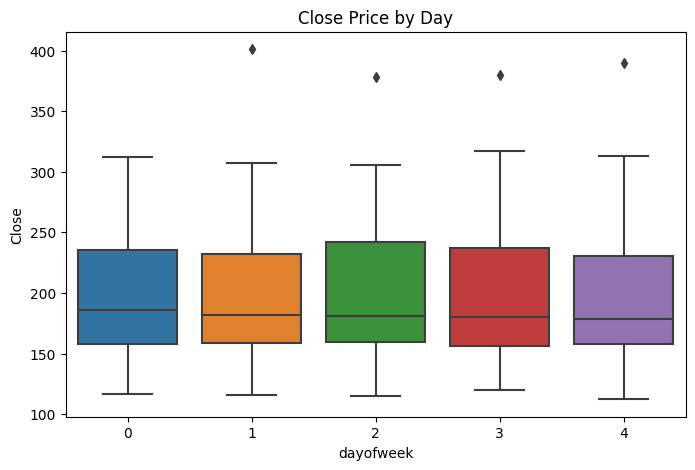

<IPython.core.display.Javascript object>

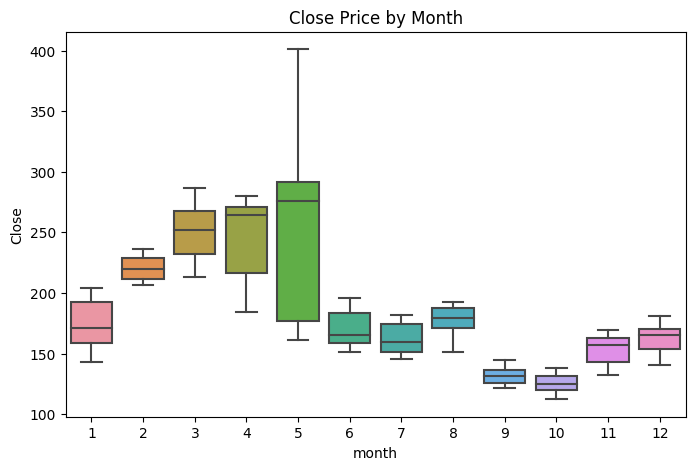

<IPython.core.display.Javascript object>

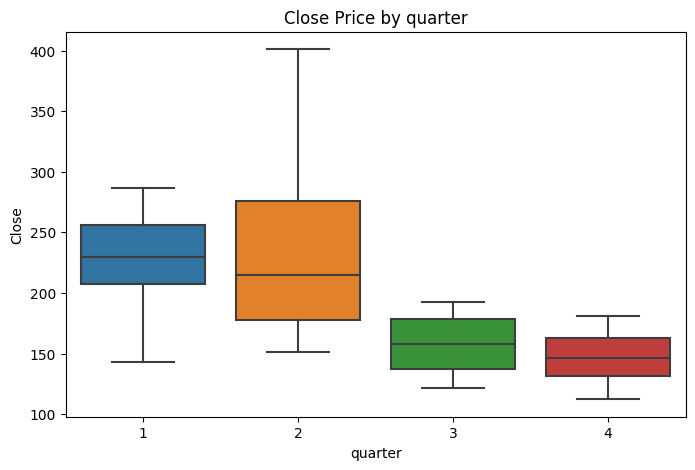

In [129]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x='dayofweek', y='Close')
ax.set_title('Close Price by Day')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x='month', y='Close')
ax.set_title('Close Price by Month')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x='quarter', y='Close')
ax.set_title('Close Price by quarter')
plt.show()

### Creating Model and Fitting Data

In [130]:
train = create_features(train)
test = create_features(test)

FEATURES = df_col
TARGET = 'Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [131]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[16:57:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:178.70690	validation_1-rmse:278.62242
[100]	validation_0-rmse:67.06838	validation_1-rmse:128.26183
[200]	validation_0-rmse:25.34807	validation_1-rmse:66.02253
[300]	validation_0-rmse:9.68785	validation_1-rmse:42.67769
[400]	validation_0-rmse:3.78219	validation_1-rmse:34.22900
[500]	validation_0-rmse:1.53688	validation_1-rmse:30.71480
[600]	validation_0-rmse:0.67622	validation_1-rmse:29.11706
[700]	validation_0-rmse:0.33661	validation_1-rmse:28.19084
[800]	validation_0-rmse:0.18397	validation_1-rmse:27.63549
[900]	validation_0-rmse:0.10635	validation_1-rmse:27.30916
[999]	validation_0-rmse:0.06347	validation_1-rmse:27.11686


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Forecasting on Test 

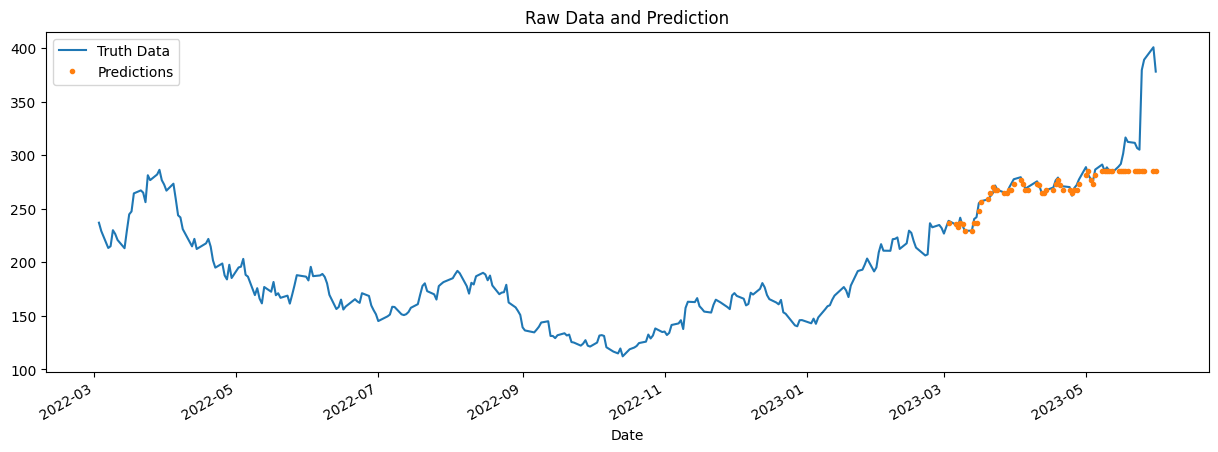

In [163]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test.loc[:,('prediction')] , how='left', left_index=True, right_index=True, suffixes=('_df', '_test'))
ax = df[['Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

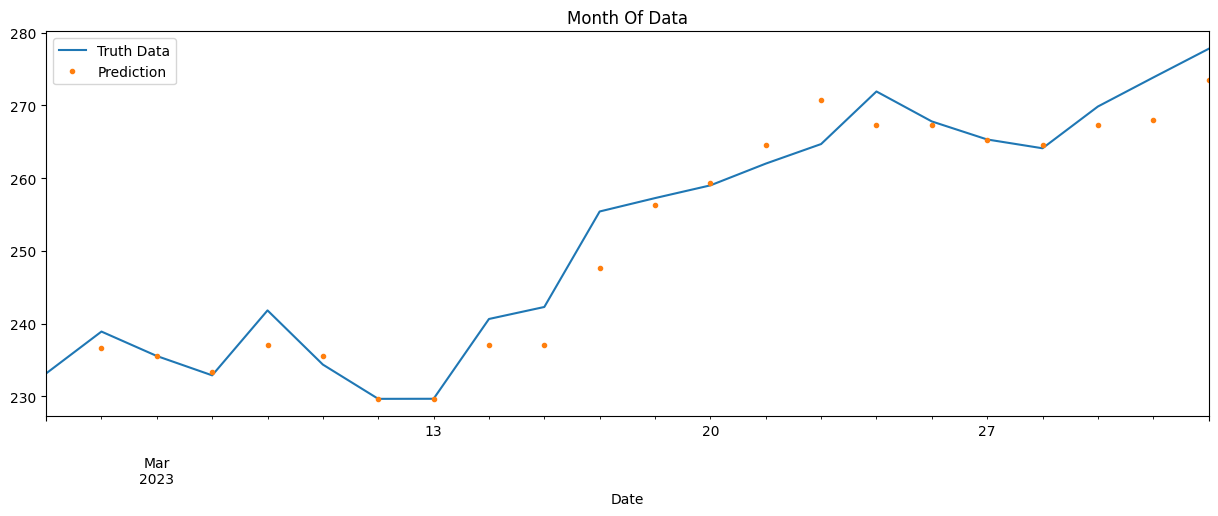

In [166]:
ax = df.loc[(df.index > '2023-03') & (df.index < '2023-04')]['Close'] \
    .plot(figsize=(15, 5), title='Month Of Data')
df.loc[(df.index > '2023-03') & (df.index < '2023-04')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()


### Score (RSME)

In [167]:
score = np.sqrt(mean_squared_error(test['Close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

<IPython.core.display.Javascript object>

RMSE Score on Test set: 27.12


In [168]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

<IPython.core.display.Javascript object>

date
2023-05-30    115.429214
2023-05-26    103.779214
2023-05-25     94.119214
2023-05-31     92.659214
2023-05-18     31.099214
2023-05-19     26.959214
2023-05-22     26.079214
2023-05-23     21.199214
2023-05-24     19.699214
2023-05-17     16.099214
Name: error, dtype: float64

# Conclusion

I believe that the model that was tested at the end was pretty accurate in predicting the price, considering the model was not tuned to better predict new data sets. All in all, this project took me about 2 weeks and I learned a lot about time series forecasting and xgboost. 

Concepts to improve on:
For my first project, I'd like to believe the result aren't bad, but the truth is that there is much to improve on. It was a bit challenging to manipulate the dataframes with time stamps. I was not used to dataframes with a a datetime index, but I pushed myself to learn how to work with them. Although I learned a lot, I would like to feel more comfortable with pandas as a library. Besides pandas, I also believe that I need to develop a better understanding of xgboost. Going through the project, I did not use a reference for any of the code and mainly went of my previous knowledge. After being humbled by errors, I decided to seek references for my code, which is where I felt the process does not need to be as complicated as it was. The code references helped me with xgboost, pandas, and much more. Additionally, I think the structuring and orgranization of the project needs work. For example, feature engineering coming before feature creation and data visualiztions for EDA showing up sporadically. I tried my best to organize the flow properly, but at some point it became clear that clean organization is something to start with, not something to come back to. I thought tidying the code might disrupt the results and I did not want to risk that.

Concepts I think I did well in:
I believe choosing the project subject was a good start for me. I felt my own interest in the project push me to improve and work harder when things got tough. I also believe that I was very resourceful throughout this project. I found all the right documentation and videos for the topics I needed help in, which aided in the completion of the project in the relatively short timespan.

Lessons Learned:
Don't reinvent the wheel, use other peoples code with the appropriate modifications
Housekeeping should be a priority not a last minute thing
Having interest in a topic goes a long way

Where to go from here:
I enjoyed this project a lot, but I wonder how the results would differ if i employed neural networks instead of regression. I would like to experiement with Keras, as I've heard it is user friendly. I would also like to explore real time streaming data on a cloud platform.